In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)
from tqdm import tqdm
import datetime
from itertools import combinations
from collections import Counter
import itertools
import re

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import Binarizer


from sklearn.metrics import precision_score , recall_score , f1_score
import lightgbm as lgb
from scipy import stats
from scipy.spatial.distance import mahalanobis
from catboost import Pool, CatBoostClassifier

In [3]:
data_train = pd.read_csv('/Users/s0c02nj/Desktop/Mortgage Modelling/CAX_MortgageModeling_Train.csv')
data_test =  pd.read_csv('/Users/s0c02nj/Desktop/Mortgage Modelling/CAX_MortgageModeling_Test.csv')
data_sub =   pd.read_csv('/Users/s0c02nj/Desktop/Mortgage Modelling/CAX_MortgageModeling_SubmissionFormat.csv')

In [4]:
data_train = data_train.drop(['Unique_ID','MORTGAGE NUMBER'],axis=1)
data_test =  data_test.drop(['Unique_ID','MORTGAGE NUMBER','RESULT'], axis=1)

In [5]:
#Train data separating the response
y       = data_train['RESULT']
x_train = data_train.drop(['RESULT'],axis=1)


In [6]:
#Test data and train data merged for pre-processing
x_comb = pd.concat([x_train,data_test],sort=False)

In [7]:
ren_cols = []

for col in tqdm(list(x_comb.columns)):
    ren_cols.append(col.replace(" ", "_"))

100%|██████████| 19/19 [00:00<00:00, 85231.85it/s]


In [8]:
x_comb.columns = ren_cols

In [9]:
cont_cols = ['PROPERTY_VALUE','MORTGAGE_PAYMENT','GDS','LTV','TDS','AMORTIZATION','MORTGAGE_AMOUNT',
             'INCOME','CREDIT_SCORE','RATE']

In [10]:
cat_cols = ['PAYMENT_FREQUENCY','PROPERTY_TYPE','FSA','TERM','AGE_RANGE','GENDER','INCOME_TYPE',
           'NAICS_CODE','MORTGAGE_PURPOSE']

In [11]:
log_transformed = ['PROPERTY_VALUE','MORTGAGE_PAYMENT','LTV','INCOME','CREDIT_SCORE','MORTGAGE_AMOUNT']

In [12]:
non_log_cols = ['GDS','LTV','TDS','AMORTIZATION','RATE']

In [13]:
for col in tqdm(cat_cols):
    le = LabelEncoder()
    x_comb[col] = le.fit_transform(x_comb[col])

100%|██████████| 9/9 [00:00<00:00, 96.59it/s]


In [14]:
z=[]
for col in tqdm(cat_cols):
    z.append((col,x_comb[col].unique().shape))

100%|██████████| 9/9 [00:00<00:00, 1499.69it/s]


In [15]:
#Label Encoding the y-var
le_y = LabelEncoder()

y_cat = le_y.fit_transform(y)

In [16]:
x_comb.skew()

PROPERTY_VALUE         5.260160
MORTGAGE_PAYMENT       4.135354
GDS                  180.294731
LTV                   -1.875249
TDS                  154.046538
AMORTIZATION          -4.740900
MORTGAGE_AMOUNT        3.665322
RATE                   1.145228
MORTGAGE_PURPOSE       0.141211
PAYMENT_FREQUENCY     -4.023413
PROPERTY_TYPE         -0.406087
TERM                   2.376065
FSA                    0.569508
AGE_RANGE              0.377381
GENDER                 0.192380
INCOME                 6.571547
INCOME_TYPE            0.619233
NAICS_CODE            -0.296763
CREDIT_SCORE          -3.087467
dtype: float64

RESULT
FUNDED        [[AxesSubplot(0.125,0.725918;0.215278x0.154082...
NOT FUNDED    [[AxesSubplot(0.125,0.725918;0.215278x0.154082...
dtype: object

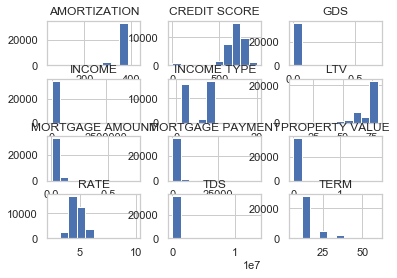

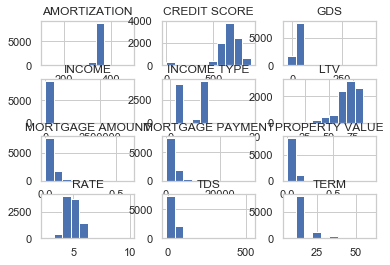

In [17]:
data_train.groupby('RESULT').hist()

In [18]:
#plt.hist(data_train[data_train['RESULT'] == 'NOT FUNDED']['AMORTIZATION'])

In [19]:
#plt.hist(data_train[data_train['RESULT'] == 'FUNDED']['AMORTIZATION'])

In [20]:
#Adaptive Bining
quantile_list = [0, .25, .5, .75, 1.]
quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']

ada_bin=[]
for col in tqdm(cont_cols):
    
    ada_bin.append(str(col)+'ada_bin')
    x_comb[str(col)+'ada_bin'] =    pd.qcut(x_comb[col].rank(method='first'), 
                                            q=quantile_list,
                                            labels=quantile_labels)

100%|██████████| 10/10 [00:00<00:00, 53.65it/s]


In [21]:
for col in tqdm(ada_bin):
    le = LabelEncoder()
    x_comb[col] = le.fit_transform(x_comb[col])

100%|██████████| 10/10 [00:00<00:00, 89.94it/s]


In [22]:
#Features for LTV
ind_ltv = []
for i in tqdm(range(0,len(x_comb))):
    ltv_val = x_comb['LTV'].iloc[0]
    
    if ltv_val>=55 and ltv_val<=78 :
        ind_ltv.append(1)
    else :
        ind_ltv.append(0)

100%|██████████| 60856/60856 [00:00<00:00, 74327.47it/s]


In [23]:
x_comb['ind_ltv']= ind_ltv

In [24]:
#Features for GDS
ind_gds_bin1 = []

for i in tqdm(range(0,len(x_comb))):
    gds_val = x_comb['GDS'].iloc[0]
    
    if gds_val>0:
        ind_gds_bin1.append(1)
    else :
        ind_gds_bin1.append(0)


100%|██████████| 60856/60856 [00:00<00:00, 77589.49it/s]


In [25]:
x_comb['ind_gds_bin1'] = ind_gds_bin1

In [26]:
#Features for GDS
ind_gds_bin2 = []

for i in tqdm(range(0,len(x_comb))):
    gds_val = x_comb['GDS'].iloc[0]
     
    if gds_val<-20 :
        ind_gds_bin2.append(0)
    
    if gds_val>=-20 and gds_val<40:
        ind_gds_bin2.append(1)
    
    elif gds_val>=-40 and gds_val<-20:
        ind_gds_bin2.append(2)
    
    elif gds_val>=40 and gds_val<90:
        ind_gds_bin2.append(3)
    
    elif gds_val>=90 and gds_val<100:
        ind_gds_bin2.append(4)
    
    elif gds_val>=90 and gds_val<100:
        ind_gds_bin2.append(5)
    
    else :
        ind_gds_bin2.append(6)

100%|██████████| 60856/60856 [00:00<00:00, 67921.53it/s]


In [27]:
x_comb['ind_gds_bin2'] = ind_gds_bin2

In [28]:
#Features for TDS
ind_tds_bin1 = []

for i in tqdm(range(0,len(x_comb))):
    tds_val = x_comb['TDS'].iloc[0]
    
    if tds_val>=40 and tds_val<=100:
        ind_tds_bin1.append(1)
    else :
        ind_tds_bin1.append(0)


100%|██████████| 60856/60856 [00:00<00:00, 77884.44it/s]


In [29]:
x_comb['ind_tds_bin1'] = ind_tds_bin1

In [30]:
#Features for GDS
ind_tds_bin2 = []

for i in tqdm(range(0,len(x_comb))):
    tds_val = x_comb['GDS'].iloc[0]
     
    if tds_val<0 :
        ind_tds_bin2.append(0)
    
    if tds_val>=0 and tds_val<40:
        ind_tds_bin2.append(1)
    
    elif tds_val>=40 and tds_val<100:
        ind_tds_bin2.append(2)
    
    elif tds_val>=100 and tds_val<200:
        ind_tds_bin2.append(3)
    
    else :
        ind_tds_bin2.append(4)

100%|██████████| 60856/60856 [00:00<00:00, 70766.49it/s]


In [31]:
x_comb['ind_tds_bin2'] = ind_tds_bin2

In [32]:
#Features for GDS
ind_am_bin2 = []

for i in tqdm(range(0,len(x_comb))):
    tds_am = x_comb['AMORTIZATION'].iloc[0]
     
    if tds_am<150 :
        ind_am_bin2.append(0)
    
    if tds_am>=150 and tds_am<200:
        ind_am_bin2.append(1)
    
    elif tds_am>=200 and tds_am<300:
        ind_am_bin2.append(2)
    
    elif tds_am>=300 and tds_am<350:
        ind_am_bin2.append(3)
    
    else :
        ind_am_bin2.append(4)

100%|██████████| 60856/60856 [00:00<00:00, 72179.86it/s]


In [33]:
x_comb['ind_am_bin2'] = ind_am_bin2

In [34]:
#new_cols = ['ind_ltv','ind_gds_bin1','ind_gds_bin2','ind_tds_bin1','ind_tds_bin2','ind_am_bin2']

In [35]:
#cat_cols = cat_cols + new_cols

In [36]:
for col in log_transformed:
    x_comb[col] = np.log1p(x_comb[col])


In [37]:
col_count = []

for col in tqdm(cont_cols):
    counter = Counter(x_comb[col])
    col_count.append(str(col)+'count')
    x_comb[str(col)+'count'] = x_comb[col].apply(lambda x:counter[x])

100%|██████████| 10/10 [00:00<00:00, 26.26it/s]


In [38]:
#Adaptive Bining
quantile_list = [0, .25, .5, .75, 1.]
quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']

ada_bin=[]
for col in tqdm(cont_cols):
    
    ada_bin.append(str(col)+'ada_bin')
    x_comb[str(col)+'ada_bin'] =    pd.qcut(x_comb[col].rank(method='first'), 
                                            q=quantile_list,
                                            labels=quantile_labels)

100%|██████████| 10/10 [00:00<00:00, 55.47it/s]


In [39]:
for col in tqdm(ada_bin):
    le = LabelEncoder()
    x_comb[col] = le.fit_transform(x_comb[col])

100%|██████████| 10/10 [00:00<00:00, 99.98it/s]


In [40]:
#cont_cols = cont_cols + col_log_count + col_count
#Binarization of count_features
bin_col =[]
for col in tqdm(col_count):
    
    bn = Binarizer(threshold=0.9)
    temp = bn.transform([x_comb[col]])[0]
    
    bin_col.append(str(col)+'count_bin')
    x_comb[str(col)+'count_bin'] = temp


100%|██████████| 10/10 [00:00<00:00, 37.48it/s]


In [41]:
#cat_cols = cat_cols + ada_bin + bin_col

In [42]:
aggs = {}

aggs['MORTGAGE_PAYMENT'] = ['median', 'mean','std']
aggs['GDS'] = ['median', 'mean','std']
aggs['LTV'] = ['median', 'mean','std']
aggs['TDS'] = ['median', 'mean','std']
aggs['AMORTIZATION'] = ['median', 'mean','std']
aggs['INCOME'] = ['median', 'mean','std']
aggs['CREDIT_SCORE'] = ['median', 'mean','std']
aggs['MORTGAGE_AMOUNT'] = ['median', 'mean','std']
aggs['PROPERTY_VALUE'] = ['median', 'mean','std']
aggs['RATE'] = ['median', 'mean','std']
aggs['PAYMENT_FREQUENCY'] = ['count','mean','median']
aggs['PROPERTY_TYPE'] = ['count','mean','median']
aggs['FSA'] = ['count','mean','median']
aggs['TERM'] = ['count','mean','median']
aggs['AGE_RANGE'] = ['count','mean','median']
aggs['GENDER'] = ['count','mean','median']
aggs['INCOME_TYPE'] = ['count','mean','median']
aggs['NAICS_CODE'] = ['count','mean','median']
aggs['MORTGAGE_PURPOSE'] = ['count','mean','median']


for col in tqdm(cat_cols):
    agg_df = x_comb.groupby(col).agg(aggs).reset_index()
    agg_df.columns = [col] + [col + '_' + c[0] +'_' + c[1] for c in agg_df.columns[1:]]
    x_comb = pd.merge(x_comb, agg_df, on= col, how="left")

100%|██████████| 9/9 [00:32<00:00,  6.60s/it]


In [44]:
#Continuous-continuous features
list_cont_cont = list(combinations(cont_cols,2))

for cols in tqdm(list_cont_cont):
    col1 = cols[0]
    col2 = cols[1]
    x_comb[col1+col2+'sum'] =  x_comb[col1] + x_comb[col2]
    x_comb[col1+col2+'mult'] = x_comb[col1] * x_comb[col2]
    x_comb[col1+col2+'div1'] = x_comb[col1] / x_comb[col2]
    x_comb[col1+col2+'div2'] = x_comb[col2] / x_comb[col1]
    x_comb[col1+col2+'sub'] =  x_comb[col1] - x_comb[col2]

100%|██████████| 45/45 [00:01<00:00, 38.08it/s]


In [45]:
#Categorical-Categorical features
list_cat_cat = list(combinations(cat_cols,2))

for cols in tqdm(list_cat_cat):
    col1 = cols[0]
    col2 = cols[1]
    x_comb['cat'+col1+col2+'mult'] = x_comb[col1]*x_comb[col2]
            

100%|██████████| 36/36 [00:00<00:00, 619.26it/s]


In [ ]:
#Categorical-Categorical features
# list_cat_cat2 = list(combinations(cat_cols,3))

# for cols in tqdm(list_cat_cat2):
#     col1 = cols[0]
#     col2 = cols[1]
#     col3 = cols[2]
#     x_comb['cat3'+col1+col2+col3+'mult'] = x_comb[col1]*x_comb[col2]*x_comb[col3]
            

In [ ]:
#Categorical-Categorical features
# list_cont_cont2 = list(combinations(cont_cols,3))

# for cols in tqdm(list_cont_cont2):
#     col1 = cols[0]
#     col2 = cols[1]
#     col3 = cols[2]
#     x_comb['cont3'+col1+col2+col3+'mult'] = x_comb[col1]*x_comb[col2]*x_comb[col3]
            

In [46]:
#Categorical-continuous
list_cat_cont = list(itertools.product(cat_cols, cont_cols))

for cols in tqdm(list_cat_cont):
    col1 = cols[0]
    col2 = cols[1]
    x_comb['cat_cont'+col1+col2+'mult'] = x_comb[col1]*x_comb[col2]

100%|██████████| 90/90 [00:00<00:00, 159.79it/s]


In [47]:
new_cols = ['ind_ltv','ind_gds_bin1','ind_gds_bin2','ind_tds_bin1','ind_tds_bin2','ind_am_bin2']
cat_cols = cat_cols + new_cols + ada_bin

In [48]:
train_x = x_comb[0:45642]
test_x =  x_comb[45642:]

In [49]:
x1_train, x1_val, y1_train, y1_val = train_test_split(train_x, y_cat,test_size=0.2,random_state=0,
                                                      stratify = y)
                                                      

In [52]:
#let us make the catboost model, use_best_model params will make the model prevent overfitting
model = CatBoostClassifier(iterations=1500, 
                           learning_rate=0.01, 
                           l2_leaf_reg=3.5, 
                           depth=8, 
                           rsm=0.98, 
                           loss_function= 'Logloss', 
                           eval_metric='AUC',
                           use_best_model=True,
                           random_seed=42)

In [53]:
model.fit(x1_train,y1_train,cat_features=cat_cols, eval_set=(x1_val,y1_val))


0:	test: 0.6460319	best: 0.6460319 (0)	total: 1.08s	remaining: 27m 2s
1:	test: 0.6650085	best: 0.6650085 (1)	total: 2.19s	remaining: 27m 20s
2:	test: 0.6699110	best: 0.6699110 (2)	total: 3.47s	remaining: 28m 53s
3:	test: 0.6777026	best: 0.6777026 (3)	total: 4.62s	remaining: 28m 48s
4:	test: 0.6781473	best: 0.6781473 (4)	total: 5.7s	remaining: 28m 24s
5:	test: 0.6807810	best: 0.6807810 (5)	total: 6.83s	remaining: 28m 21s
6:	test: 0.6815356	best: 0.6815356 (6)	total: 7.98s	remaining: 28m 22s
7:	test: 0.6836352	best: 0.6836352 (7)	total: 8.26s	remaining: 25m 40s
8:	test: 0.6867298	best: 0.6867298 (8)	total: 9.36s	remaining: 25m 49s
9:	test: 0.6878651	best: 0.6878651 (9)	total: 10.5s	remaining: 26m
10:	test: 0.6877205	best: 0.6878651 (9)	total: 11.6s	remaining: 26m 5s
11:	test: 0.6891824	best: 0.6891824 (11)	total: 12.7s	remaining: 26m 12s
12:	test: 0.6909843	best: 0.6909843 (12)	total: 13.8s	remaining: 26m 17s
13:	test: 0.6907738	best: 0.6909843 (12)	total: 14.9s	remaining: 26m 21s
14:	te

113:	test: 0.7283260	best: 0.7283260 (113)	total: 2m 8s	remaining: 26m 1s
114:	test: 0.7286639	best: 0.7286639 (114)	total: 2m 9s	remaining: 25m 59s
115:	test: 0.7288128	best: 0.7288128 (115)	total: 2m 10s	remaining: 25m 57s
116:	test: 0.7287932	best: 0.7288128 (115)	total: 2m 10s	remaining: 25m 44s
117:	test: 0.7290227	best: 0.7290227 (117)	total: 2m 11s	remaining: 25m 42s
118:	test: 0.7293699	best: 0.7293699 (118)	total: 2m 12s	remaining: 25m 40s
119:	test: 0.7294460	best: 0.7294460 (119)	total: 2m 13s	remaining: 25m 38s
120:	test: 0.7293465	best: 0.7294460 (119)	total: 2m 14s	remaining: 25m 36s
121:	test: 0.7294455	best: 0.7294460 (119)	total: 2m 15s	remaining: 25m 34s
122:	test: 0.7294534	best: 0.7294534 (122)	total: 2m 16s	remaining: 25m 32s
123:	test: 0.7298072	best: 0.7298072 (123)	total: 2m 17s	remaining: 25m 31s
124:	test: 0.7301787	best: 0.7301787 (124)	total: 2m 19s	remaining: 25m 29s
125:	test: 0.7305138	best: 0.7305138 (125)	total: 2m 20s	remaining: 25m 26s
126:	test: 0.73

222:	test: 0.7416073	best: 0.7416073 (222)	total: 4m 8s	remaining: 23m 40s
223:	test: 0.7416761	best: 0.7416761 (223)	total: 4m 9s	remaining: 23m 38s
224:	test: 0.7417755	best: 0.7417755 (224)	total: 4m 10s	remaining: 23m 36s
225:	test: 0.7418193	best: 0.7418193 (225)	total: 4m 11s	remaining: 23m 35s
226:	test: 0.7417860	best: 0.7418193 (225)	total: 4m 12s	remaining: 23m 34s
227:	test: 0.7418894	best: 0.7418894 (227)	total: 4m 13s	remaining: 23m 32s
228:	test: 0.7419159	best: 0.7419159 (228)	total: 4m 14s	remaining: 23m 31s
229:	test: 0.7420972	best: 0.7420972 (229)	total: 4m 15s	remaining: 23m 29s
230:	test: 0.7421963	best: 0.7421963 (230)	total: 4m 16s	remaining: 23m 28s
231:	test: 0.7421768	best: 0.7421963 (230)	total: 4m 17s	remaining: 23m 27s
232:	test: 0.7422674	best: 0.7422674 (232)	total: 4m 18s	remaining: 23m 27s
233:	test: 0.7423604	best: 0.7423604 (233)	total: 4m 19s	remaining: 23m 26s
234:	test: 0.7423821	best: 0.7423821 (234)	total: 4m 21s	remaining: 23m 25s
235:	test: 0.7

331:	test: 0.7471408	best: 0.7471408 (331)	total: 6m 9s	remaining: 21m 39s
332:	test: 0.7472661	best: 0.7472661 (332)	total: 6m 10s	remaining: 21m 38s
333:	test: 0.7472430	best: 0.7472661 (332)	total: 6m 11s	remaining: 21m 36s
334:	test: 0.7473304	best: 0.7473304 (334)	total: 6m 12s	remaining: 21m 35s
335:	test: 0.7473076	best: 0.7473304 (334)	total: 6m 13s	remaining: 21m 34s
336:	test: 0.7473232	best: 0.7473304 (334)	total: 6m 13s	remaining: 21m 29s
337:	test: 0.7473388	best: 0.7473388 (337)	total: 6m 14s	remaining: 21m 28s
338:	test: 0.7474448	best: 0.7474448 (338)	total: 6m 15s	remaining: 21m 26s
339:	test: 0.7474532	best: 0.7474532 (339)	total: 6m 15s	remaining: 21m 22s
340:	test: 0.7474550	best: 0.7474550 (340)	total: 6m 16s	remaining: 21m 21s
341:	test: 0.7475150	best: 0.7475150 (341)	total: 6m 18s	remaining: 21m 20s
342:	test: 0.7475191	best: 0.7475191 (342)	total: 6m 19s	remaining: 21m 19s
343:	test: 0.7475492	best: 0.7475492 (343)	total: 6m 20s	remaining: 21m 17s
344:	test: 0.

440:	test: 0.7493745	best: 0.7493745 (440)	total: 7m 58s	remaining: 19m 8s
441:	test: 0.7493683	best: 0.7493745 (440)	total: 7m 59s	remaining: 19m 7s
442:	test: 0.7493365	best: 0.7493745 (440)	total: 8m	remaining: 19m 6s
443:	test: 0.7493614	best: 0.7493745 (440)	total: 8m 1s	remaining: 19m 5s
444:	test: 0.7493686	best: 0.7493745 (440)	total: 8m 2s	remaining: 19m 4s
445:	test: 0.7494188	best: 0.7494188 (445)	total: 8m 3s	remaining: 19m 2s
446:	test: 0.7494057	best: 0.7494188 (445)	total: 8m 4s	remaining: 19m 1s
447:	test: 0.7493905	best: 0.7494188 (445)	total: 8m 5s	remaining: 19m
448:	test: 0.7495143	best: 0.7495143 (448)	total: 8m 6s	remaining: 18m 59s
449:	test: 0.7495588	best: 0.7495588 (449)	total: 8m 7s	remaining: 18m 58s
450:	test: 0.7495626	best: 0.7495626 (450)	total: 8m 9s	remaining: 18m 57s
451:	test: 0.7495474	best: 0.7495626 (450)	total: 8m 10s	remaining: 18m 56s
452:	test: 0.7495876	best: 0.7495876 (452)	total: 8m 11s	remaining: 18m 55s
453:	test: 0.7496233	best: 0.749623

549:	test: 0.7507208	best: 0.7507208 (549)	total: 9m 52s	remaining: 17m 4s
550:	test: 0.7507303	best: 0.7507303 (550)	total: 9m 53s	remaining: 17m 1s
551:	test: 0.7507701	best: 0.7507701 (551)	total: 9m 54s	remaining: 17m
552:	test: 0.7507675	best: 0.7507701 (551)	total: 9m 54s	remaining: 16m 58s
553:	test: 0.7507800	best: 0.7507800 (553)	total: 9m 54s	remaining: 16m 55s
554:	test: 0.7507898	best: 0.7507898 (554)	total: 9m 54s	remaining: 16m 53s
555:	test: 0.7507962	best: 0.7507962 (555)	total: 9m 56s	remaining: 16m 52s
556:	test: 0.7508312	best: 0.7508312 (556)	total: 9m 57s	remaining: 16m 50s
557:	test: 0.7508480	best: 0.7508480 (557)	total: 9m 58s	remaining: 16m 49s
558:	test: 0.7508374	best: 0.7508480 (557)	total: 9m 59s	remaining: 16m 48s
559:	test: 0.7508708	best: 0.7508708 (559)	total: 10m	remaining: 16m 47s
560:	test: 0.7509013	best: 0.7509013 (560)	total: 10m 1s	remaining: 16m 46s
561:	test: 0.7509322	best: 0.7509322 (561)	total: 10m 2s	remaining: 16m 45s
562:	test: 0.7509218	

657:	test: 0.7519494	best: 0.7519494 (657)	total: 11m 40s	remaining: 14m 56s
658:	test: 0.7519575	best: 0.7519575 (658)	total: 11m 41s	remaining: 14m 55s
659:	test: 0.7519474	best: 0.7519575 (658)	total: 11m 42s	remaining: 14m 54s
660:	test: 0.7519153	best: 0.7519575 (658)	total: 11m 44s	remaining: 14m 53s
661:	test: 0.7519255	best: 0.7519575 (658)	total: 11m 45s	remaining: 14m 52s
662:	test: 0.7519706	best: 0.7519706 (662)	total: 11m 46s	remaining: 14m 51s
663:	test: 0.7519690	best: 0.7519706 (662)	total: 11m 47s	remaining: 14m 50s
664:	test: 0.7519875	best: 0.7519875 (664)	total: 11m 48s	remaining: 14m 49s
665:	test: 0.7520222	best: 0.7520222 (665)	total: 11m 49s	remaining: 14m 48s
666:	test: 0.7520171	best: 0.7520222 (665)	total: 11m 50s	remaining: 14m 47s
667:	test: 0.7520417	best: 0.7520417 (667)	total: 11m 51s	remaining: 14m 46s
668:	test: 0.7520761	best: 0.7520761 (668)	total: 11m 52s	remaining: 14m 45s
669:	test: 0.7520761	best: 0.7520761 (668)	total: 11m 52s	remaining: 14m 43s

765:	test: 0.7526013	best: 0.7526110 (762)	total: 13m 33s	remaining: 12m 59s
766:	test: 0.7525972	best: 0.7526110 (762)	total: 13m 33s	remaining: 12m 57s
767:	test: 0.7526491	best: 0.7526491 (767)	total: 13m 34s	remaining: 12m 56s
768:	test: 0.7526771	best: 0.7526771 (768)	total: 13m 35s	remaining: 12m 55s
769:	test: 0.7526588	best: 0.7526771 (768)	total: 13m 36s	remaining: 12m 53s
770:	test: 0.7526829	best: 0.7526829 (770)	total: 13m 37s	remaining: 12m 52s
771:	test: 0.7526656	best: 0.7526829 (770)	total: 13m 38s	remaining: 12m 52s
772:	test: 0.7527035	best: 0.7527035 (772)	total: 13m 39s	remaining: 12m 51s
773:	test: 0.7526977	best: 0.7527035 (772)	total: 13m 41s	remaining: 12m 50s
774:	test: 0.7527096	best: 0.7527096 (774)	total: 13m 42s	remaining: 12m 49s
775:	test: 0.7527084	best: 0.7527096 (774)	total: 13m 42s	remaining: 12m 47s
776:	test: 0.7526915	best: 0.7527096 (774)	total: 13m 43s	remaining: 12m 46s
777:	test: 0.7527847	best: 0.7527847 (777)	total: 13m 44s	remaining: 12m 45s

873:	test: 0.7532387	best: 0.7532387 (873)	total: 15m 17s	remaining: 10m 57s
874:	test: 0.7532584	best: 0.7532584 (874)	total: 15m 18s	remaining: 10m 56s
875:	test: 0.7532802	best: 0.7532802 (875)	total: 15m 19s	remaining: 10m 55s
876:	test: 0.7532838	best: 0.7532838 (876)	total: 15m 20s	remaining: 10m 54s
877:	test: 0.7532890	best: 0.7532890 (877)	total: 15m 21s	remaining: 10m 53s
878:	test: 0.7532807	best: 0.7532890 (877)	total: 15m 23s	remaining: 10m 52s
879:	test: 0.7532735	best: 0.7532890 (877)	total: 15m 24s	remaining: 10m 51s
880:	test: 0.7532693	best: 0.7532890 (877)	total: 15m 25s	remaining: 10m 50s
881:	test: 0.7532624	best: 0.7532890 (877)	total: 15m 25s	remaining: 10m 48s
882:	test: 0.7532584	best: 0.7532890 (877)	total: 15m 25s	remaining: 10m 46s
883:	test: 0.7532489	best: 0.7532890 (877)	total: 15m 26s	remaining: 10m 45s
884:	test: 0.7532652	best: 0.7532890 (877)	total: 15m 27s	remaining: 10m 44s
885:	test: 0.7532592	best: 0.7532890 (877)	total: 15m 28s	remaining: 10m 43s

981:	test: 0.7542625	best: 0.7542629 (979)	total: 17m	remaining: 8m 58s
982:	test: 0.7542813	best: 0.7542813 (982)	total: 17m 1s	remaining: 8m 57s
983:	test: 0.7542630	best: 0.7542813 (982)	total: 17m 2s	remaining: 8m 56s
984:	test: 0.7542594	best: 0.7542813 (982)	total: 17m 3s	remaining: 8m 55s
985:	test: 0.7542608	best: 0.7542813 (982)	total: 17m 4s	remaining: 8m 54s
986:	test: 0.7542687	best: 0.7542813 (982)	total: 17m 5s	remaining: 8m 53s
987:	test: 0.7542705	best: 0.7542813 (982)	total: 17m 6s	remaining: 8m 51s
988:	test: 0.7543030	best: 0.7543030 (988)	total: 17m 7s	remaining: 8m 51s
989:	test: 0.7543057	best: 0.7543057 (989)	total: 17m 8s	remaining: 8m 49s
990:	test: 0.7543819	best: 0.7543819 (990)	total: 17m 9s	remaining: 8m 48s
991:	test: 0.7543888	best: 0.7543888 (991)	total: 17m 11s	remaining: 8m 47s
992:	test: 0.7543630	best: 0.7543888 (991)	total: 17m 12s	remaining: 8m 47s
993:	test: 0.7543440	best: 0.7543888 (991)	total: 17m 13s	remaining: 8m 46s
994:	test: 0.7543820	best

1088:	test: 0.7549790	best: 0.7549790 (1088)	total: 18m 47s	remaining: 7m 5s
1089:	test: 0.7550313	best: 0.7550313 (1089)	total: 18m 48s	remaining: 7m 4s
1090:	test: 0.7550535	best: 0.7550535 (1090)	total: 18m 49s	remaining: 7m 3s
1091:	test: 0.7550521	best: 0.7550535 (1090)	total: 18m 50s	remaining: 7m 2s
1092:	test: 0.7550506	best: 0.7550535 (1090)	total: 18m 51s	remaining: 7m 1s
1093:	test: 0.7550594	best: 0.7550594 (1093)	total: 18m 52s	remaining: 7m
1094:	test: 0.7550629	best: 0.7550629 (1094)	total: 18m 53s	remaining: 6m 59s
1095:	test: 0.7550687	best: 0.7550687 (1095)	total: 18m 54s	remaining: 6m 58s
1096:	test: 0.7550820	best: 0.7550820 (1096)	total: 18m 55s	remaining: 6m 57s
1097:	test: 0.7550814	best: 0.7550820 (1096)	total: 18m 55s	remaining: 6m 55s
1098:	test: 0.7551034	best: 0.7551034 (1098)	total: 18m 56s	remaining: 6m 54s
1099:	test: 0.7551016	best: 0.7551034 (1098)	total: 18m 57s	remaining: 6m 53s
1100:	test: 0.7550917	best: 0.7551034 (1098)	total: 18m 58s	remaining: 6m

1194:	test: 0.7556184	best: 0.7556184 (1194)	total: 20m 38s	remaining: 5m 16s
1195:	test: 0.7556292	best: 0.7556292 (1195)	total: 20m 39s	remaining: 5m 15s
1196:	test: 0.7556404	best: 0.7556404 (1196)	total: 20m 40s	remaining: 5m 14s
1197:	test: 0.7556515	best: 0.7556515 (1197)	total: 20m 41s	remaining: 5m 13s
1198:	test: 0.7556553	best: 0.7556553 (1198)	total: 20m 43s	remaining: 5m 12s
1199:	test: 0.7556541	best: 0.7556553 (1198)	total: 20m 44s	remaining: 5m 11s
1200:	test: 0.7556737	best: 0.7556737 (1200)	total: 20m 45s	remaining: 5m 10s
1201:	test: 0.7556880	best: 0.7556880 (1201)	total: 20m 46s	remaining: 5m 9s
1202:	test: 0.7557390	best: 0.7557390 (1202)	total: 20m 47s	remaining: 5m 8s
1203:	test: 0.7557590	best: 0.7557590 (1203)	total: 20m 48s	remaining: 5m 7s
1204:	test: 0.7557483	best: 0.7557590 (1203)	total: 20m 49s	remaining: 5m 5s
1205:	test: 0.7557520	best: 0.7557590 (1203)	total: 20m 51s	remaining: 5m 5s
1206:	test: 0.7557346	best: 0.7557590 (1203)	total: 20m 52s	remaining

1300:	test: 0.7567809	best: 0.7567891 (1298)	total: 22m 45s	remaining: 3m 28s
1301:	test: 0.7567762	best: 0.7567891 (1298)	total: 22m 46s	remaining: 3m 27s
1302:	test: 0.7567732	best: 0.7567891 (1298)	total: 22m 48s	remaining: 3m 26s
1303:	test: 0.7567695	best: 0.7567891 (1298)	total: 22m 49s	remaining: 3m 25s
1304:	test: 0.7567630	best: 0.7567891 (1298)	total: 22m 51s	remaining: 3m 24s
1305:	test: 0.7567595	best: 0.7567891 (1298)	total: 22m 52s	remaining: 3m 23s
1306:	test: 0.7567628	best: 0.7567891 (1298)	total: 22m 53s	remaining: 3m 22s
1307:	test: 0.7567725	best: 0.7567891 (1298)	total: 22m 55s	remaining: 3m 21s
1308:	test: 0.7567823	best: 0.7567891 (1298)	total: 22m 56s	remaining: 3m 20s
1309:	test: 0.7567739	best: 0.7567891 (1298)	total: 22m 57s	remaining: 3m 19s
1310:	test: 0.7567855	best: 0.7567891 (1298)	total: 22m 58s	remaining: 3m 18s
1311:	test: 0.7568458	best: 0.7568458 (1311)	total: 22m 59s	remaining: 3m 17s
1312:	test: 0.7568466	best: 0.7568466 (1312)	total: 23m	remainin

1406:	test: 0.7575640	best: 0.7575790 (1397)	total: 24m 48s	remaining: 1m 38s
1407:	test: 0.7575641	best: 0.7575790 (1397)	total: 24m 49s	remaining: 1m 37s
1408:	test: 0.7575622	best: 0.7575790 (1397)	total: 24m 50s	remaining: 1m 36s
1409:	test: 0.7575670	best: 0.7575790 (1397)	total: 24m 51s	remaining: 1m 35s
1410:	test: 0.7575724	best: 0.7575790 (1397)	total: 24m 52s	remaining: 1m 34s
1411:	test: 0.7575857	best: 0.7575857 (1411)	total: 24m 54s	remaining: 1m 33s
1412:	test: 0.7575999	best: 0.7575999 (1412)	total: 24m 55s	remaining: 1m 32s
1413:	test: 0.7576200	best: 0.7576200 (1413)	total: 24m 57s	remaining: 1m 31s
1414:	test: 0.7576210	best: 0.7576210 (1414)	total: 24m 58s	remaining: 1m 30s
1415:	test: 0.7576295	best: 0.7576295 (1415)	total: 25m	remaining: 1m 28s
1416:	test: 0.7576251	best: 0.7576295 (1415)	total: 25m 3s	remaining: 1m 28s
1417:	test: 0.7576360	best: 0.7576360 (1417)	total: 25m 7s	remaining: 1m 27s
1418:	test: 0.7576346	best: 0.7576360 (1417)	total: 25m 10s	remaining:

In [54]:
#last let us make the submission,note that you have to make the pred to be int!
pred = model.predict_proba(test_x)
preds= pred[:,1]

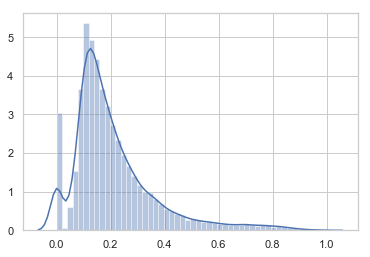

In [56]:
sns.distplot(preds)

In [ ]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

In [ ]:
random_state = 42
np.random.seed(random_state)

lgb_params = {
    "objective" : "binary",
    'metric':{lgb_f1_score},
    "boosting": 'gbdt',
    "max_depth" : 6,
    "num_leaves" : 30,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.6,
    "feature_fraction" : 0.09,
    "min_data_in_leaf":  40,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    'min_split_gain': .001,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    "bagging_seed" : random_state,
    "verbosity" : 1,
    "is_unbalance":'TRUE',
    "seed": random_state
}

In [ ]:
trn_data = lgb.Dataset(x1_train, label= y1_train)
val_data = lgb.Dataset(x1_val,   label=  y1_val)

In [ ]:
lgb_clf = lgb.train(lgb_params,
                    trn_data,
                    13000,
                    valid_sets = [trn_data, val_data],
                    early_stopping_rounds=3000,
                    feval=lgb_f1_score
                    )

In [ ]:
# oof = np.zeros(len(train_df))
# predictions = np.zeros(len(test_df))

# for train_index, valid_index in kf.split(feature_matrix_train):
    
#     d_train = lgb.Dataset(feature_matrix_train.iloc[train_index], label=y.iloc[train_index])
#     d_val =   lgb.Dataset(feature_matrix_train.iloc[valid_index], label=y.iloc[valid_index])

#     clf = lgb.train(params, d_train, 150000, verbose_eval=1000, 
#                     valid_sets = [d_train, d_val], early_stopping_rounds = 500,
#                     categorical_feature=categorical_features)
    
#     oof[valid_index] = clf.predict(feature_matrix_train.iloc[valid_index])

#     predictions += clf.predict(feature_matrix_test)

In [80]:
### funded : 0,  not funded 1
best_thresh = None
val_score = 0

for thresh in np.linspace(start = 0.1, stop = 0.7, num = 40):
    
    val_preds = model.predict(x1_val)
    ans = [1 if (val > thresh) else 0 for val in val_preds]
    
    score = f1_score(y1_val, ans, average='macro')
    print("Thresh", thresh, "F1 score:", score)
    
    if score > val_score:
        val_score = score
        best_thresh = thresh

        
print("\nThresh", best_thresh, "F1 score:", val_score)


Thresh 0.1 F1 score: 0.5961617966649844
Thresh 0.11538461538461539 F1 score: 0.5961617966649844
Thresh 0.13076923076923078 F1 score: 0.5961617966649844
Thresh 0.14615384615384616 F1 score: 0.5961617966649844
Thresh 0.16153846153846155 F1 score: 0.5961617966649844
Thresh 0.1769230769230769 F1 score: 0.5961617966649844
Thresh 0.1923076923076923 F1 score: 0.5961617966649844
Thresh 0.20769230769230768 F1 score: 0.5961617966649844
Thresh 0.22307692307692306 F1 score: 0.5961617966649844
Thresh 0.23846153846153845 F1 score: 0.5961617966649844
Thresh 0.25384615384615383 F1 score: 0.5961617966649844
Thresh 0.2692307692307692 F1 score: 0.5961617966649844
Thresh 0.2846153846153846 F1 score: 0.5961617966649844
Thresh 0.3 F1 score: 0.5961617966649844
Thresh 0.3153846153846154 F1 score: 0.5961617966649844
Thresh 0.33076923076923076 F1 score: 0.5961617966649844
Thresh 0.34615384615384615 F1 score: 0.5961617966649844
Thresh 0.3615384615384615 F1 score: 0.5961617966649844
Thresh 0.3769230769230769 F1 s

KeyboardInterrupt: 

In [ ]:
#('\nThresh', 0.5948717948717949, 'F1 score:', 0.6749024684341038)

In [ ]:
fig, ax = plt.subplots(figsize=(12,30))
lgb.plot_importance(lgb_clf, max_num_features=190, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=12)
plt.show()

In [ ]:
pred = lgb_clf.predict(test_x)

In [81]:
y_pred = ['NOT FUNDED' if x >= 0.279 else 'FUNDED' for x in preds]

In [82]:
print (y_pred.count('NOT FUNDED'))
print (y_pred.count('FUNDED'))

3350
11864


In [83]:
y_pred.count('NOT FUNDED')/ (y_pred.count('NOT FUNDED') + y_pred.count('FUNDED'))

0.22019192848691993

In [84]:
data_sub['Result_Predicted'] = y_pred

In [85]:
data_sub.to_csv('/Users/s0c02nj/Desktop/Mortgage Modelling/Submission_catb.csv',index=False)

Error Analysis

In [ ]:
pred_val  = lgb_clf.predict(x1_val)

In [ ]:
err = (y1_val - pred_val)**2

In [ ]:
plt.scatter(x1_val['AMORTIZATION'],err)

In [ ]:
a = pd.DataFrame([[1,2,3,4],[2,3,4,],[2,3,4,5],[4,5,6,]])

In [ ]:
a.columns = ['k1','k2','k3','k4']

In [ ]:
a = a.replace(np.nan,'nan',regex=True)

In [ ]:
a.groupby('k4')

In [ ]:
a